# Importing Labiraries 📚

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import torch.nn as nn
#import torch.nn.functional as F
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

# Importing Data 📥

In [2]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
y = train_df['Survived']
train_row = train_df.shape[0]

data = pd.concat((train_df, test_df)).reset_index(drop = True)

# Data Exploration 🔍

data.info()

<AxesSubplot:>

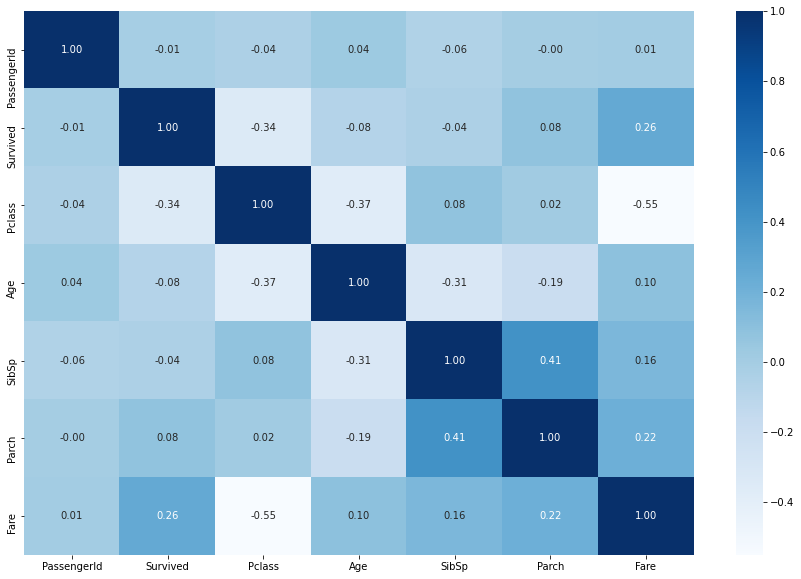

In [4]:
num_var = [col for col in train_df.columns if train_df[col].dtype != 'object']

plt.figure(figsize = (15,10))
sns.heatmap(train_df[num_var].corr(),cmap='Blues', annot = True,fmt = '.2f')

## Univariant Exploration 📊

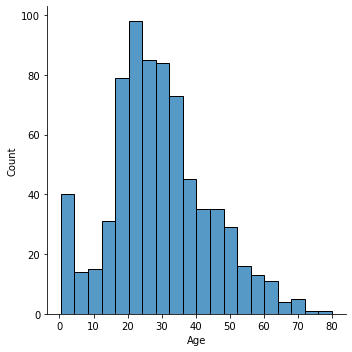

In [5]:
###  Age

sns.displot(data = train_df, x = 'Age')

**Foundings** 📝



<AxesSubplot:xlabel='Pclass', ylabel='count'>

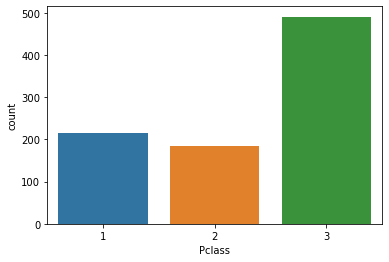

In [6]:
###  Pclass

sns.countplot(data = train_df, x = 'Pclass')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

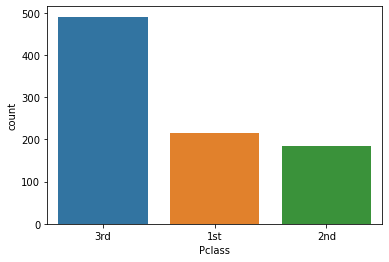

In [7]:
### We found Pclass is a categorical variable, 1 means first class, 2 means second class , 3  means 3rd class
### so it would be better if we mapped these values with their meanings to make it easier to handle later

train_df['Pclass'].replace({1:'1st', 2:'2nd', 3:'3rd'}, inplace  = True)
sns.countplot(data = train_df, x = 'Pclass')

<AxesSubplot:xlabel='SibSp', ylabel='count'>

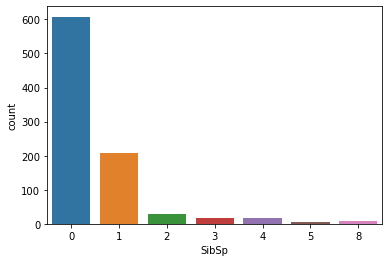

In [8]:
###   SibSp

sns.countplot(data = train_df, x = 'SibSp')

<AxesSubplot:xlabel='Parch', ylabel='count'>

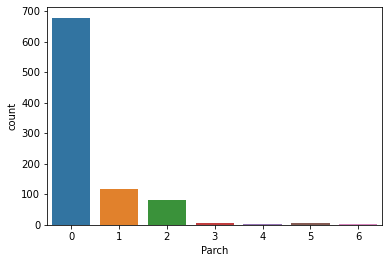

In [9]:
###   Parch

sns.countplot(data = train_df, x = 'Parch')

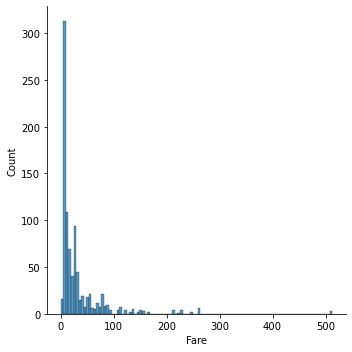

In [10]:
###   Fare

sns.displot(data = train_df, x = 'Fare')

In [11]:
train_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [33]:
###   it's bretty clear that Fare has outliers that would affect our model performance later
###   so need to drop these outliers
###   I will use IQR to detect outliers in Fare column

Q1 = train_df['Fare'].quantile(0.25)
Q3 = train_df['Fare'].quantile(0.75)
IQR = Q3 - Q1

train_df = train_df.drop(train_df[((train_df['Fare'] < (Q1 - 1.5 * IQR)) | (train_df['Fare'] > (Q3 + 1.5 * IQR)))].index)

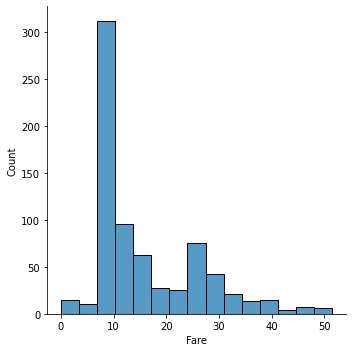

In [34]:
sns.displot(data = train_df, x = 'Fare')

## Bivariant Exploration 📈

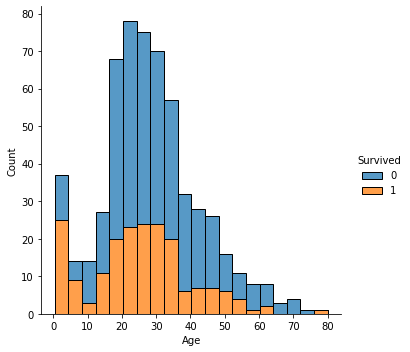

In [38]:
sns.displot(data = train_df, x = 'Age', hue  = 'Survived',multiple="stack" )

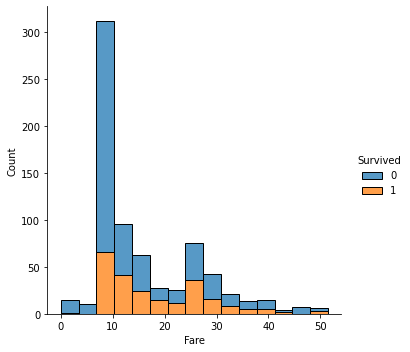

In [39]:
sns.displot(data = train_df, x = 'Fare', hue  = 'Survived',multiple="stack" )

/home/passant/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


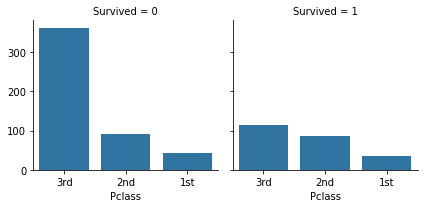

In [42]:
g = sns.FacetGrid(data = train_df, col = 'Survived')
g.map(sns.countplot,  'Pclass')

/home/passant/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


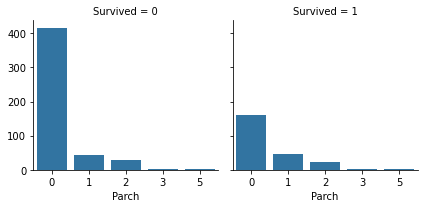

In [43]:
g = sns.FacetGrid(data = train_df, col = 'Survived')
g.map(sns.countplot,  'Parch')

/home/passant/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


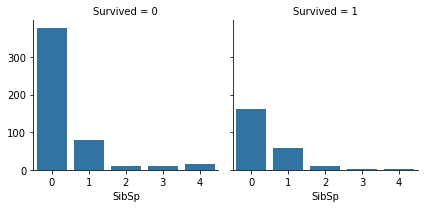

In [45]:
g = sns.FacetGrid(data = train_df, col = 'Survived')
g.map(sns.countplot,  'SibSp')

/home/passant/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


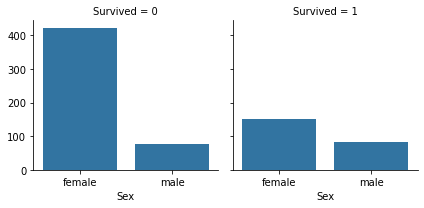

In [46]:
g = sns.FacetGrid(data = train_df, col = 'Survived')
g.map(sns.countplot, 'Sex')

/home/passant/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


KeyError: "None of [Index(['embarked'], dtype='object')] are in the [columns]"

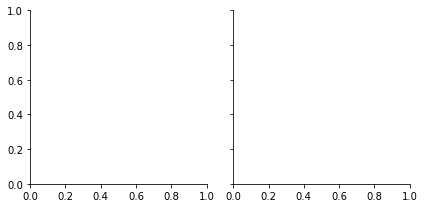

In [47]:
g = sns.FacetGrid(data = train_df, col = 'Survived')
g.map(sns.countplot,  'embarked')

# Data Preprocessing

### (Read & Separate) samples & labels

In [ ]:
# load data
train_data = pd.read_csv('./train.csv')

#separate the target col
train_label = train_data.Survived

# Drop unused cols
features_toDrop = ['Survived', 'Ticket', 'Cabin', 'Name', 'PassengerId']
train_data = train_data.drop(features_toDrop, axis = 1)

## Feature Engineering

### Useful Functions

In [ ]:
def create_Fsize_feature(data):
    """
    This function creates a new feature represent the family size
        then encodes it to 4 columns (categories: 1, 2, 3:4, >5)
        
    """
    # Create new feature (family size)
    data["Fsize"] = data["SibSp"] + data["Parch"] + 1
    
    # encode the family size feature
    data['Single'] = data['Fsize'].map(lambda s: 1 if s == 1 else 0)
    data['SmallF'] = data['Fsize'].map(lambda s: 1 if  s == 2  else 0)
    data['MedF'] = data['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    data['LargeF'] = data['Fsize'].map(lambda s: 1 if s >= 5 else 0)
    
    return data

In [ ]:
def sex_embark_encode(data):
    """
    This function encodes the features: Sex, Embarked
    
    Returns the dataframe
    """
    
    data['Sex'] = data['Sex'].astype('category')
    data['Sex'] = data['Sex'].cat.codes
    
    data['Embarked'] = data['Embarked'].fillna('S') 
    data['Embarked'] = data['Embarked'].astype('category')
    data['Embarked'] = data['Embarked'].cat.codes
    
    return data

In [ ]:
train_data = create_Fsize_feature(train_data)
train_data = sex_embark_encode(train_data)

In [ ]:
print("The dataframe columns are:\n")
print(train_data.columns)

### Data Cleaning

In [ ]:
Mean = train_data.loc[:,'Age'].mean()
print("Mean of Age is:", Mean)

train_data['Age'] = train_data['Age'].fillna(Mean) # Fill the nan values with the mean of Age values

In [ ]:
print("Number of nan values in the whole df:\n", train_data.isnull().sum())

## Building the Model

In [ ]:
sc = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size = 0.2, shuffle = True)

sc.fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
#lr = LogisticRegression(random_state = 0)  # Test acc: 0.76076 with scaling
                                           # Test acc: 0.75358 without scaling which is weird for me XD
    
#lr = MLPClassifier(hidden_layer_sizes = [100,10,10], random_state = 0, max_iter = 1000)  # Test acc: 0.7655 with scaling

lr= GradientBoostingClassifier(random_state = 0)
lr = lr.fit(X_train, y_train)

print("Train Accuracy is: ", lr.score(X_train, y_train))
print("Test Accuracy is: ", lr.score(X_test, y_test))

# Testing the model

In [ ]:
path = './test.csv'

test_data = pd.read_csv(path)

In [ ]:
test_data = create_Fsize_feature(test_data)

In [ ]:
#Encoding Categorical Variables
test_data = sex_embark_encode(test_data)

#### Check the encoding to be the same in both train & test sets

In [ ]:
print("male is encoded in train data as: ",train_data['Sex'][0])
print("female is encoded in train data as: ",train_data['Sex'][1])

print("male is encoded in test data as: ",test_data['Sex'][0])
print("female is encoded in test data as: ",test_data['Sex'][1])

In [ ]:
test_data.isnull().sum()

In [ ]:
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].dropna().mean()) # for test data

mean_val= test_data['Age'].mean()
test_data['Age']=test_data['Age'].fillna(mean_val)


features_toDrop = ['Ticket', 'Cabin', 'Name', 'PassengerId']
test_data = test_data.drop(features_toDrop, axis = 1)

In [ ]:
Ids = test_data.index
test_data = sc.transform(test_data)

In [ ]:
def submit():
    Y = lr.predict(test_data)
    pred = {"PassengerId": Ids, "Survived": Y}
    pred = pd.DataFrame(pred)
    pred.to_csv('Subb.csv', index = False, encoding = 'utf-8')

In [ ]:
submit()